<a href="https://colab.research.google.com/github/jayarnim/project-Comparative_Analysis_of_Changes_in_Influence_of_Market_Demand_Determinants/blob/main/code/05_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,578 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and dire

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/2023-2_MachineLearning/Project/

Mounted at /content/drive
/content/drive/MyDrive/2023-2_MachineLearning/Project


In [ ]:
from common import data, variable, sector
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def RF_MODEL(i,j,params):
    # 변수 설정
    X = variable.FEATURE
    y = variable.TARGET

    # 파일 불러오기
    df = pd.read_csv(data.PARSEDLIST[i])

    # 코로나 전후 나누기
    df = df[df['년도'].isin(variable.EXOGENOUS['년도'][j])]

    dfx = df[X]
    dfy = df[y]

    # 이상치 제거
    q1 = dfx.quantile(0.25)
    q3 = dfx.quantile(0.75)
    IQR = q3 - q1

    c = dfx[(dfx < q1 - 1.5*IQR) | (dfx > q3 + 1.5*IQR)]
    dfx = dfx[dfx != c].dropna()

    df = pd.concat([dfx,dfy],axis=1).dropna()
    dfx = df[X]
    dfy = df[y]

    # 데이터 분할
    x_trn, x_tst, y_trn, y_tst = train_test_split(
        dfx, dfy,
        test_size = 0.3,
        shuffle = True,
        random_state = 121
        )

    # 정규화
    scaler = MinMaxScaler()
    X_trn = scaler.fit_transform(x_trn)
    X_tst = scaler.fit_transform(x_tst)

    # 훈련 데이터 모델 훈련 및 예측과 평가지표
    model = RandomForestRegressor(**params)
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_trn)
    trn_rmse = np.sqrt(mean_squared_error(y_true=y_trn, y_pred=y_pred))
    trn_mae = mean_absolute_error(y_true=y_trn, y_pred=y_pred)

    # 테스트 데이터 모델 훈련 및 예측과 평가지표
    y_pred = model.predict(X_tst)
    tst_rmse = np.sqrt(mean_squared_error(y_true=y_tst, y_pred=y_pred))
    tst_mae = mean_absolute_error(y_true=y_tst, y_pred=y_pred)

    print(f"\nFeature_Importances on training set using best model={model.feature_importances_}")

    print("===========================================================================================================")

    print("Training Set")
    print(f"RMSE on training set using best model={trn_rmse:.4f}")
    print(f"MAE on training set using best model={trn_mae:.4f}")

    print("===========================================================================================================")

    print("Test Set")
    print(f"RMSE on test set using best model={tst_rmse:.4f}")
    print(f"MAE on test set using best model={tst_mae:.4f}")

    return [(model.feature_importances_,), (trn_rmse, trn_mae), (tst_rmse, tst_mae)]

In [ ]:
params = {
    'n_estimators': 100,
    'max_depth': 20,
    'max_features': 'auto',
    'oob_score': True,
    'min_samples_leaf': 1,
    'random_state': 121
    }

In [ ]:
importance_list = []
trn_list = []
tst_list = []

for i in tqdm(iterable=range(len(data.PARSEDLIST)), desc="업종"):
    if i in [4]:
        continue

    else:
        importance_j = []
        trn_j = []
        tst_j = []

        for j in range(len(variable.EXOGENOUS['년도'])):
            result_list = RF_MODEL(i,j,params)
            importance_j.append(result_list[0])
            trn_j.append(result_list[1])
            tst_j.append(result_list[2])

        importance_list.append(importance_j)
        trn_list.append(trn_j)
        tst_list.append(tst_j)

업종:   0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.10261444 0.16705761 0.12711935 0.14696646 0.19261304 0.2636291 ]
Training Set
RMSE on training set using best model=73583.0663
MAE on training set using best model=40594.4984
Test Set
RMSE on test set using best model=205468.7120
MAE on test set using best model=117254.8130


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:   8%|▊         | 1/13 [00:15<03:03, 15.32s/it]


Feature_Importances on training set using best model=[0.14767994 0.17690868 0.08440741 0.14556358 0.16003632 0.28540406]
Training Set
RMSE on training set using best model=39104.9066
MAE on training set using best model=20073.6521
Test Set
RMSE on test set using best model=94655.5443
MAE on test set using best model=46295.6060


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.12045722 0.14684365 0.14241914 0.16091465 0.19969682 0.22966853]
Training Set
RMSE on training set using best model=29428.0681
MAE on training set using best model=14620.6300
Test Set
RMSE on test set using best model=92577.0172
MAE on test set using best model=41022.5250


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  15%|█▌        | 2/13 [00:30<02:45, 15.02s/it]


Feature_Importances on training set using best model=[0.13703716 0.21125421 0.05798913 0.14174109 0.19990315 0.25207525]
Training Set
RMSE on training set using best model=12870.7444
MAE on training set using best model=6051.4636
Test Set
RMSE on test set using best model=43910.9958
MAE on test set using best model=16279.6803


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.20149606 0.14344232 0.14228143 0.1520591  0.13289518 0.22782591]
Training Set
RMSE on training set using best model=503.8915
MAE on training set using best model=246.5296
Test Set
RMSE on test set using best model=1489.6604
MAE on test set using best model=655.7268


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  23%|██▎       | 3/13 [00:39<02:06, 12.67s/it]


Feature_Importances on training set using best model=[0.13060552 0.20341699 0.10176812 0.19613688 0.12552311 0.24254938]
Training Set
RMSE on training set using best model=273.9192
MAE on training set using best model=96.6114
Test Set
RMSE on test set using best model=1090.6361
MAE on test set using best model=291.1497


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.13340961 0.18324153 0.18546371 0.14927365 0.14137809 0.20723341]
Training Set
RMSE on training set using best model=19480.2169
MAE on training set using best model=10118.7914
Test Set
RMSE on test set using best model=56206.0971
MAE on test set using best model=33922.8872


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  31%|███       | 4/13 [00:52<01:53, 12.67s/it]


Feature_Importances on training set using best model=[0.14191819 0.21545994 0.09132733 0.15993468 0.10919586 0.282164  ]
Training Set
RMSE on training set using best model=7848.3633
MAE on training set using best model=4584.3549
Test Set
RMSE on test set using best model=20554.9229
MAE on test set using best model=11638.0977


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.07821979 0.33413488 0.15664595 0.1694514  0.15232411 0.10922387]
Training Set
RMSE on training set using best model=11360.3264
MAE on training set using best model=5671.4151
Test Set
RMSE on test set using best model=37151.8293
MAE on test set using best model=16022.7787


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  46%|████▌     | 6/13 [01:06<01:06,  9.57s/it]


Feature_Importances on training set using best model=[0.11443893 0.26992522 0.11902921 0.14919395 0.15476998 0.19264272]
Training Set
RMSE on training set using best model=7250.3733
MAE on training set using best model=3518.7475
Test Set
RMSE on test set using best model=13748.6989
MAE on test set using best model=6464.2644


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.17380392 0.13703827 0.16760594 0.17392423 0.16833138 0.17929626]
Training Set
RMSE on training set using best model=2641.6016
MAE on training set using best model=1181.1327
Test Set
RMSE on test set using best model=8415.5561
MAE on test set using best model=3882.4881


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  54%|█████▍    | 7/13 [01:14<00:55,  9.27s/it]


Feature_Importances on training set using best model=[0.20297785 0.16923038 0.11201392 0.09257947 0.14045707 0.28274132]
Training Set
RMSE on training set using best model=236.2431
MAE on training set using best model=114.6425
Test Set
RMSE on test set using best model=876.3069
MAE on test set using best model=502.3047


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.09396691 0.09925581 0.1933076  0.24842767 0.2237441  0.14129791]
Training Set
RMSE on training set using best model=13598.4348
MAE on training set using best model=3040.9550
Test Set
RMSE on test set using best model=24087.8227
MAE on test set using best model=8460.3911


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  62%|██████▏   | 8/13 [01:29<00:53, 10.69s/it]


Feature_Importances on training set using best model=[0.03666274 0.03653611 0.02420678 0.04276104 0.05019828 0.80963505]
Training Set
RMSE on training set using best model=5686.6342
MAE on training set using best model=1797.1300
Test Set
RMSE on test set using best model=20571.2084
MAE on test set using best model=4805.6899


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.10719751 0.15670699 0.14989125 0.15005146 0.25307282 0.18307998]
Training Set
RMSE on training set using best model=29213.4165
MAE on training set using best model=18290.8963
Test Set
RMSE on test set using best model=91877.7805
MAE on test set using best model=63597.6077


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  69%|██████▉   | 9/13 [01:42<00:45, 11.48s/it]


Feature_Importances on training set using best model=[0.17681128 0.17751297 0.09981542 0.16868013 0.14531098 0.23186922]
Training Set
RMSE on training set using best model=19350.8194
MAE on training set using best model=10815.0013
Test Set
RMSE on test set using best model=45270.5779
MAE on test set using best model=23801.7064


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.07347251 0.03068417 0.62942039 0.06931413 0.09899111 0.09811769]
Training Set
RMSE on training set using best model=12798.9937
MAE on training set using best model=1274.5441
Test Set
RMSE on test set using best model=23269.4815
MAE on test set using best model=3611.4643


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  77%|███████▋  | 10/13 [01:53<00:34, 11.35s/it]


Feature_Importances on training set using best model=[0.0254555  0.0167587  0.60790293 0.02530004 0.13903117 0.18555167]
Training Set
RMSE on training set using best model=5694.7845
MAE on training set using best model=708.4459
Test Set
RMSE on test set using best model=15687.6384
MAE on test set using best model=2264.7382


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.05049667 0.13688072 0.28561559 0.25429597 0.14609014 0.12662091]
Training Set
RMSE on training set using best model=927.5453
MAE on training set using best model=314.5623
Test Set
RMSE on test set using best model=3445.5321
MAE on test set using best model=851.6136


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  85%|████████▍ | 11/13 [02:04<00:22, 11.19s/it]


Feature_Importances on training set using best model=[0.13995224 0.06562123 0.10111376 0.45658538 0.15379302 0.08293437]
Training Set
RMSE on training set using best model=1071.9950
MAE on training set using best model=232.7557
Test Set
RMSE on test set using best model=1424.7319
MAE on test set using best model=440.6096


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.40150905 0.07721581 0.19129668 0.05256043 0.17780032 0.09961771]
Training Set
RMSE on training set using best model=9882.6825
MAE on training set using best model=1759.3706
Test Set
RMSE on test set using best model=76235.6706
MAE on test set using best model=8322.6544


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종:  92%|█████████▏| 12/13 [02:12<00:10, 10.23s/it]


Feature_Importances on training set using best model=[0.14242859 0.00375799 0.10500949 0.02760106 0.03525449 0.68594838]
Training Set
RMSE on training set using best model=18902.7691
MAE on training set using best model=1985.9428
Test Set
RMSE on test set using best model=73599.0470
MAE on test set using best model=11160.3587


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature_Importances on training set using best model=[0.09282093 0.20023271 0.24182977 0.1523336  0.15444156 0.15834143]
Training Set
RMSE on training set using best model=2731.1865
MAE on training set using best model=1019.0227
Test Set
RMSE on test set using best model=4712.4878
MAE on test set using best model=2333.8413


<ipython-input-3-7e10e8cc6c00>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_trn, y_trn)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
업종: 100%|██████████| 13/13 [02:23<00:00, 11.06s/it]


Feature_Importances on training set using best model=[0.10257692 0.3121271  0.13365098 0.12692532 0.13723231 0.18748737]
Training Set
RMSE on training set using best model=2586.3255
MAE on training set using best model=1038.1752
Test Set
RMSE on test set using best model=9362.4590
MAE on test set using best model=2978.4101


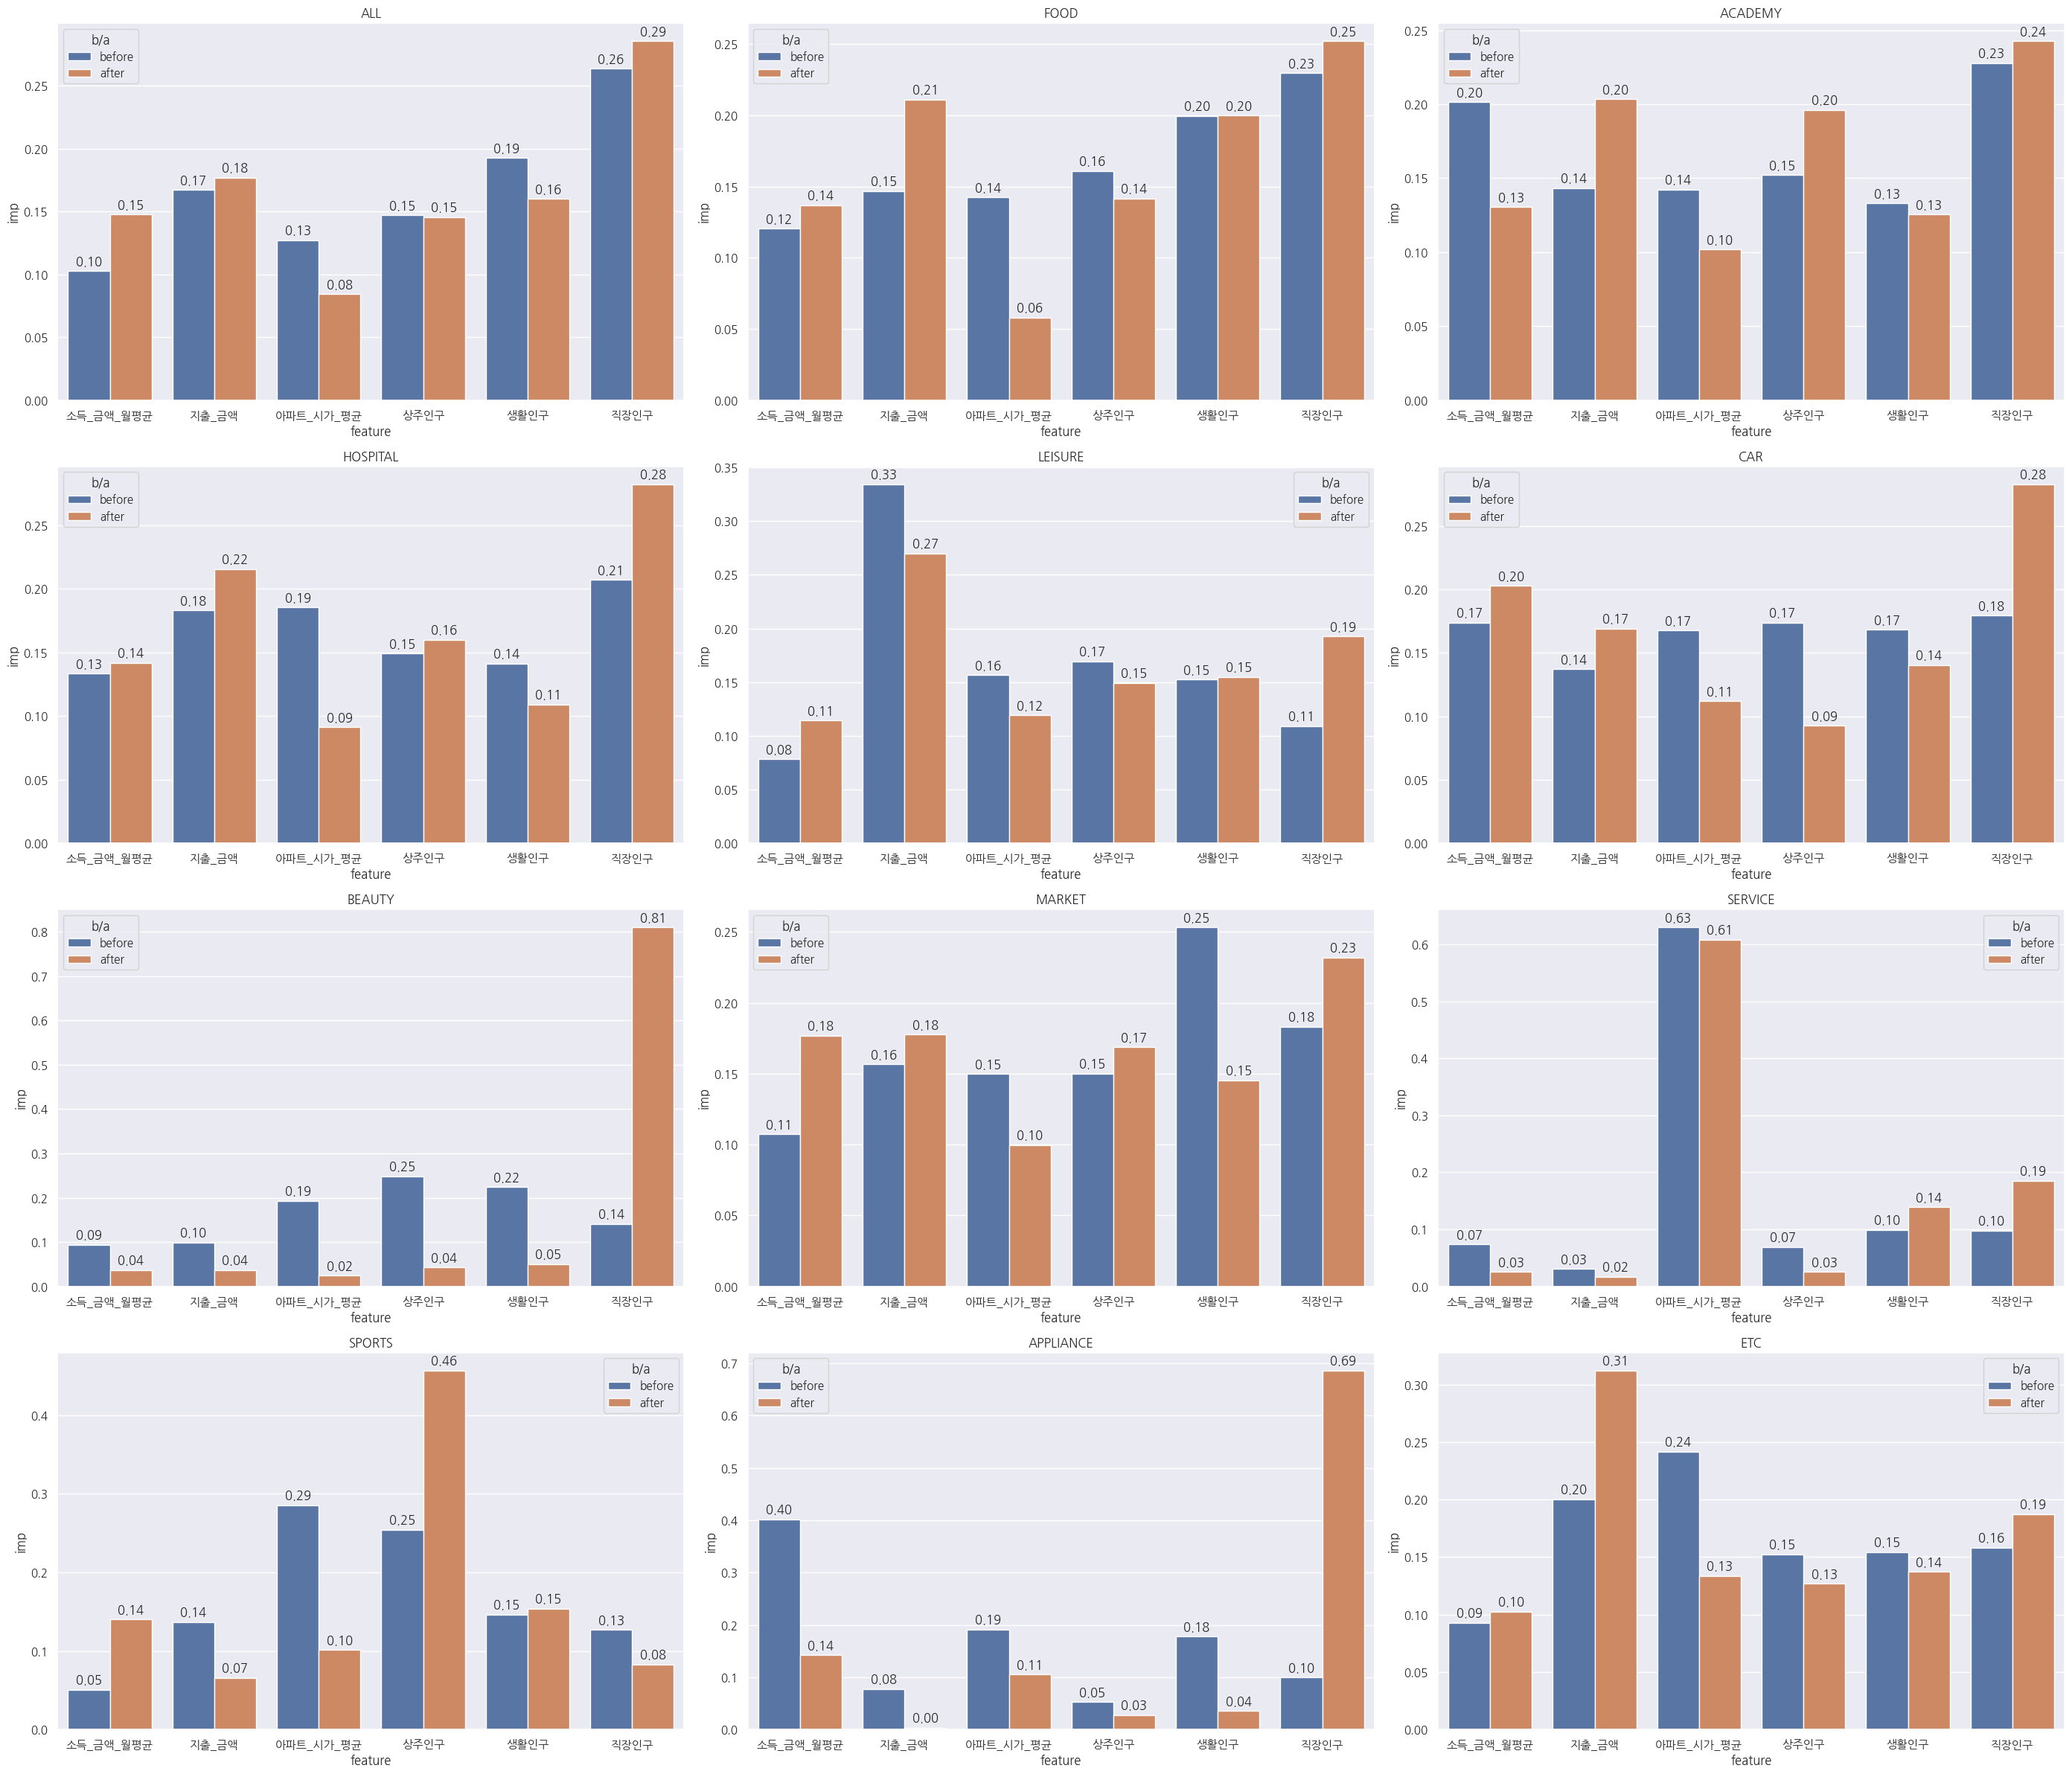

In [ ]:
before_imp = [importance_list[i][0] for i in range(len(importance_list))]
after_imp = [importance_list[i][1] for i in range(len(importance_list))]
df_name_list = [sector.NAMELIST[i] for i in range(len(sector.NAMELIST)) if i not in [4]]


fig = plt.figure(figsize = (28, 24))


for i in range(len(before_imp)):
    imp_before = {
        "feature":variable.FEATURE,
        "imp":before_imp[i][0]
        }
    imp_before = pd.DataFrame(imp_before)
    imp_before['b/a'] = "before"


    imp_after = {
        "feature":variable.FEATURE,
        "imp":after_imp[i][0]
        }
    imp_after = pd.DataFrame(imp_after)
    imp_after['b/a'] = "after"


    imp_merge = pd.merge(imp_before, imp_after, how='outer')


    globals()[f"ax{i}"] = fig.add_subplot(4, 3, i+1)

    sns.set(
        font_scale = 1,
        font = "NanumGothic"
        )

    globals()[f"ax{i}"].set_title(f"{df_name_list[i]}")

    globals()[f"ax{i}"] = sns.barplot(
        x="feature",
        y="imp",
        data=imp_merge,
        hue='b/a'
        )

    for p in globals()[f"ax{i}"].patches:
        globals()[f"ax{i}"].annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center',
            xytext = (0, 9),
            textcoords = 'offset points'
            )


fig.tight_layout()
fig.show()